In [1]:
import numpy as np
from qiskit.circuit.library import TwoLocal
from IPython.display import display
import qtpu

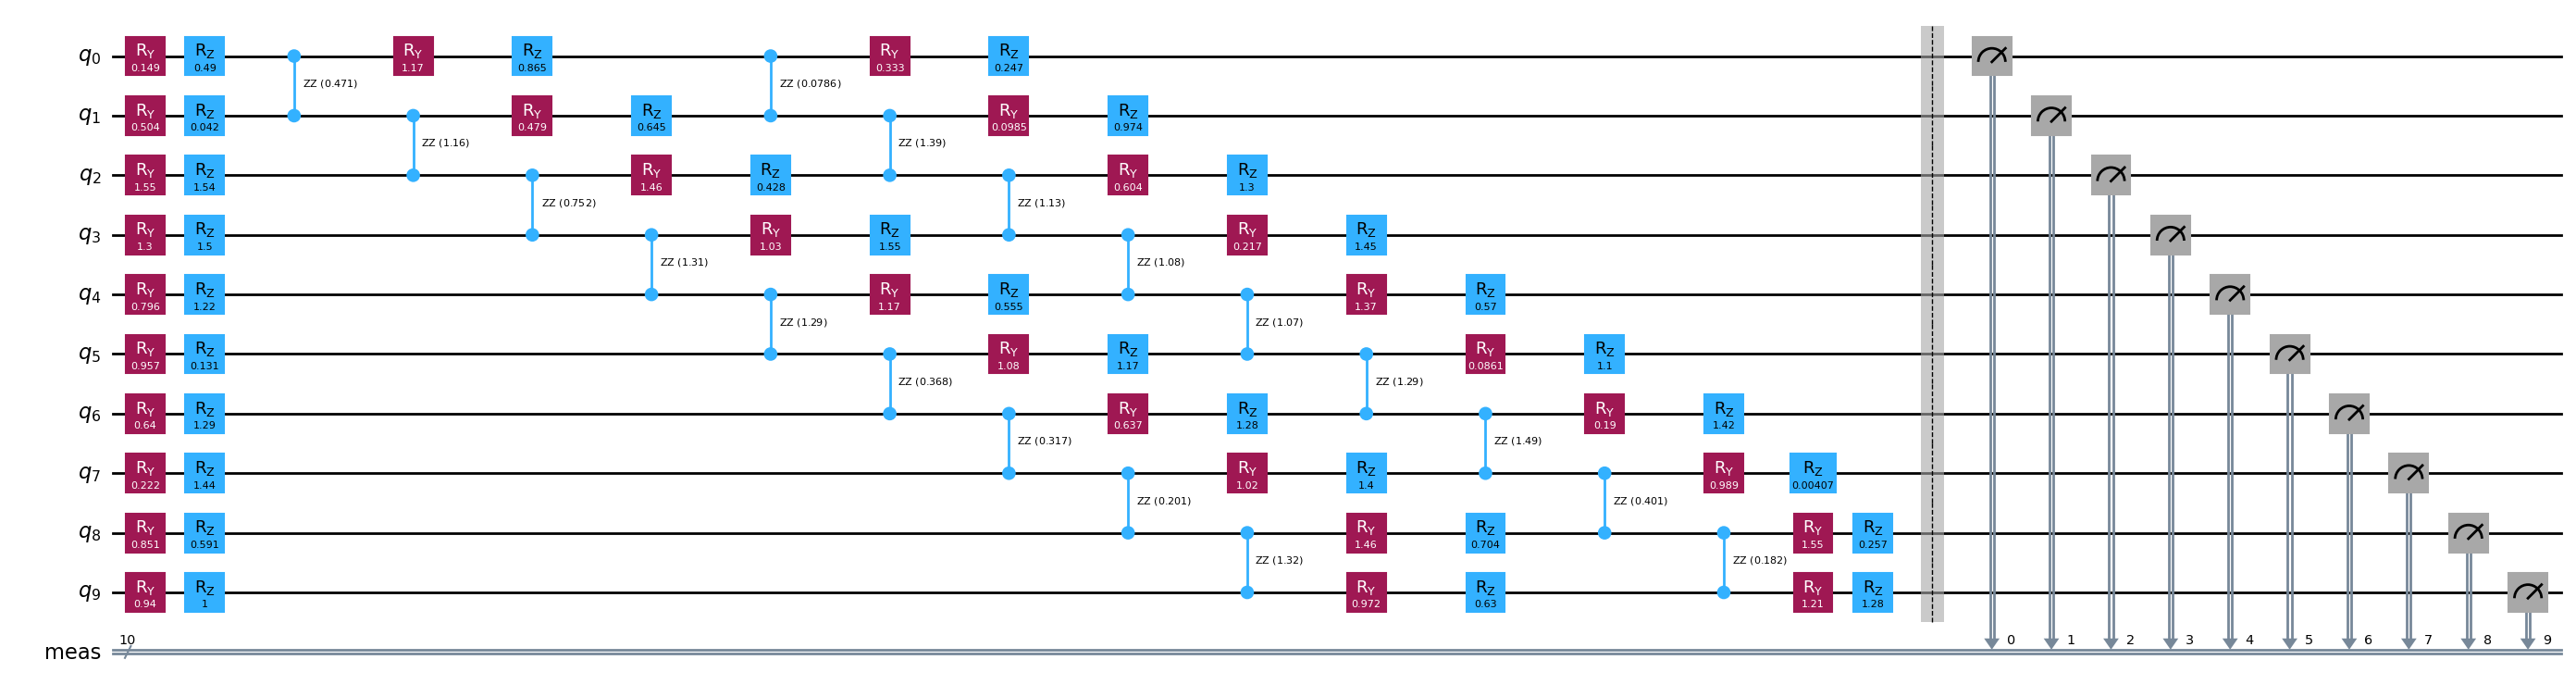

In [2]:
N = 10
circuit = TwoLocal(N, ["ry", "rz"], "rzz", entanglement="linear", reps=2).decompose()
circuit = circuit.assign_parameters(
    {param: np.random.rand() * np.pi / 2 for param in circuit.parameters}
)

circuit.measure_all()

circuit.draw("mpl", fold=-1)

In [3]:
cut_circuit = qtpu.cut(circuit, num_qubits=N//4, show_progress_bar=True, n_trials=10)
cut_circuit.draw("mpl", fold=-1)

  0%|          | 0/10 [00:00<?, ?it/s]

[W 2024-10-21 15:55:45,783] Trial 5 failed with parameters: {'compress': '2q', 'choose_leaf': 'qubits', 'random_strength': 9.526607851301915, 'weight_edges': 'log', 'imbalance': 0.3940569744452692, 'imbalance_decay': -0.6859858719225542, 'parts': 7, 'parts_decay': 0.403305406687246, 'mode': 'direct', 'objective': 'cut', 'fix_output_nodes': ''} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/di75piq/qtpu/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/di75piq/qtpu/qtpu/compiler/opt.py", line 251, in <lambda>
    lambda trial: objective(
                  ^^^^^^^^^^
  File "/home/di75piq/qtpu/qtpu/compiler/opt.py", line 199, in objective
    cut_circuit, meta = optimize(
                        ^^^^^^^^^
  File "/home/di75piq/qtpu/qtpu/compiler/opt.py", line 131, in optimize
    membership = partition_fn(
          

KeyboardInterrupt: 

Postprocessing Overhead: 5400
Number of circuits: 5256


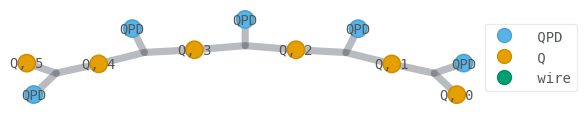

In [4]:
htn = qtpu.circuit_to_hybrid_tn(cut_circuit, num_samples=np.inf)
print(f"Postprocessing Overhead: {htn.contraction_cost()}")
print(f"Number of circuits: {htn.num_circuits()}")
htn.draw()

In [5]:
from qiskit_aer.primitives import EstimatorV2

# get the result <ZZ..Z>
est = EstimatorV2()
res = qtpu.contract(htn, EstimatorV2())
print(f"qTPU result: {res}")

Evaluating 5256 circuits
qTPU result: -0.0009189122948828877


In [6]:
perf_res = (
    est.run(
        [(circuit.remove_final_measurements(inplace=False), "Z" * circuit.num_qubits)]
    )
    .result()[0]
    .data.evs
)
print(f"Qiskit result: {perf_res}")
print(f"Error: {abs(res - perf_res)}")

Qiskit result: -0.000918912294882841
Error: 4.662069341687669e-17


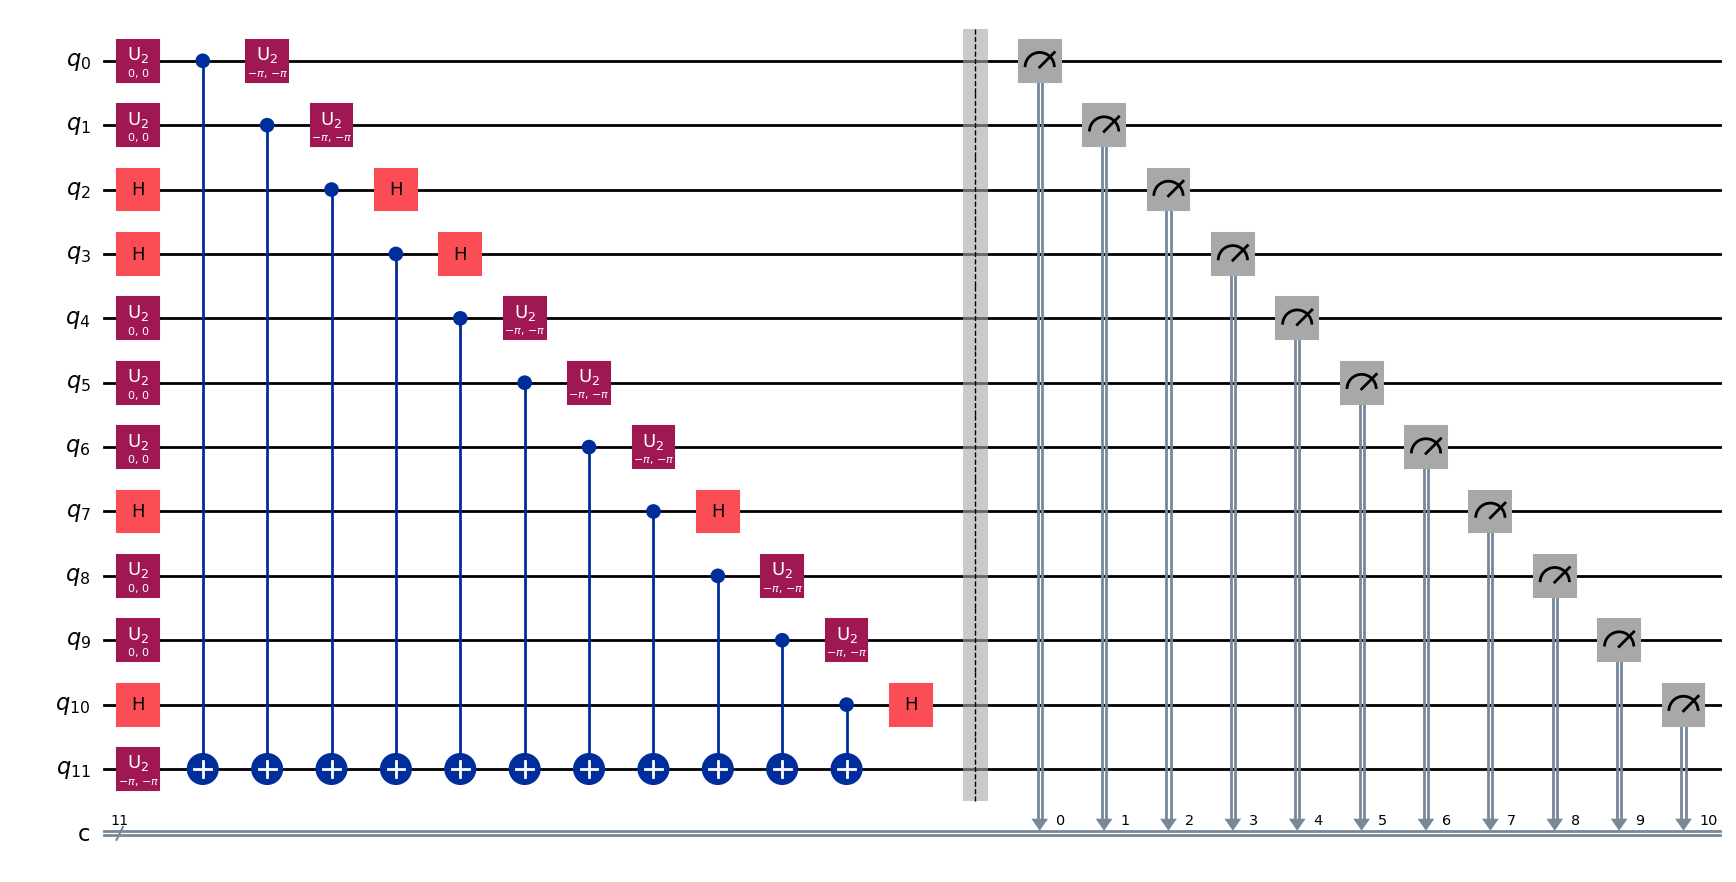

In [14]:
from mqt.bench import CompilerSettings, QiskitSettings, TKETSettings, get_benchmark

from qtpu.helpers import remove_barriers

qc_algorithmic_level = get_benchmark(benchmark_name="ae", level="indep", circuit_size=12, kwargs={"entanglement": "linear"})
qc_algorithmic_level.draw(output="mpl", fold=-1)

In [15]:
from qtpu.circuit import cuts_to_moves, subcircuits
from mqt.bench.utils import calc_supermarq_features


def super_features(circuit):
    circuit = cuts_to_moves(circuit)
    subcircs = subcircuits(circuit)
    return calc_supermarq_features(
        subcircs[0]
    )

In [16]:

features = calc_supermarq_features(qc_algorithmic_level)
print(features)

SupermarqFeatures(program_communication=0.16666666666666666, critical_depth=1.0, entanglement_ratio=0.3235294117647059, parallelism=0.12987012987012986, liveness=0.3333333333333333)


In [19]:
from qtpu.compiler.dep_graph import circuit_to_dep_graph, reduce_deps_greedy, uncycle, remove_critical_gates

cut_circuit = remove_critical_gates(remove_barriers(qc_algorithmic_level), 3)
print(super_features(cut_circuit))
# cut_circuit.draw(output="mpl")
# import networkx as nx
# graph = circuit_to_dep_graph(remove_barriers(qc_algorithmic_level))
# print(nx.is_directed_acyclic_graph(graph))
# uncycle(graph)
# nx.draw(graph, with_labels=True)

SupermarqFeatures(program_communication=0.25, critical_depth=1.0, entanglement_ratio=0.3181818181818182, parallelism=0.17142857142857146, liveness=0.45)
